In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os

In [2]:
data_dir = 'data/attwood/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/attwood/'
os.system('mkdir -p {}'.format(plot_dir))

0

In [22]:
momentum = 168.9 # MeV/c , 172
m = 105.7 # MeV
E = np.round(np.sqrt(momentum**2 + m**2))


E_i = E # momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = 100000 
    
deflection = [
    'bremstsaiapproximation', # 'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoborogpetrukhin', # 'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 71530

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 10.9 # in cm = 109 mm

In [23]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Hydrogen(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
'''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
'''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

# Run simulation

In [24]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

100%|██████████| 100000/100000 [02:02<00:00, 815.55it/s]


In [25]:
tracks_109 = []
for track in tracks:
    if track.track_propagated_distances()[-1] == 10.9:
        tracks_109.append(track)

In [26]:
tracks_109_zenith = []
tracks_109_azimuth = []
tracks_109_x = []
tracks_109_y = []
tracks_109_z = []
tracks_109_pos_x = []
tracks_109_pos_y = []
tracks_109_pos_z = []
for track in tqdm(tracks_109):
    tracks_109_zenith.append(track.track_directions()[-1].spherical_coordinates[2])
    tracks_109_azimuth.append(track.track_directions()[-1].spherical_coordinates[1])
    tracks_109_x.append(track.track_directions()[-1].x)
    tracks_109_y.append(track.track_directions()[-1].y)
    tracks_109_z.append(track.track_directions()[-1].z)
    tracks_109_pos_x.append(track.track_positions()[-1].x)
    tracks_109_pos_y.append(track.track_positions()[-1].y)
    tracks_109_pos_z.append(track.track_positions()[-1].z)

100%|██████████| 99992/99992 [01:31<00:00, 1096.51it/s]


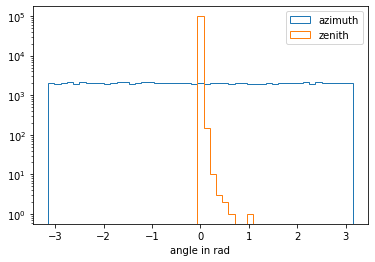

In [27]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_109_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_109_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

In [28]:
# reproduziere den plot von attwood -> irgendwie muss der winkel noch berücksichtigt werden, wie?
# lese schon mal die daten von attwood ein und erzeuge dann einen auf 100% normierten bar plot

In [29]:
# read in unfoled data of Attwood, angle in rad and probability in percent
Attwood = pd.read_csv('data/attwood/Attwood_unfolded_data.csv', sep=';', decimal=',', names=['angle', 'probability']) 
print('total probability attwood: ', np.sum(Attwood.probability))
GEANT4 = pd.read_csv('data/attwood/Attwood_GEANT4.csv', sep=';', decimal=',', names=['angle', 'probability']) 

total probability attwood:  151.87151660028977


8043.0

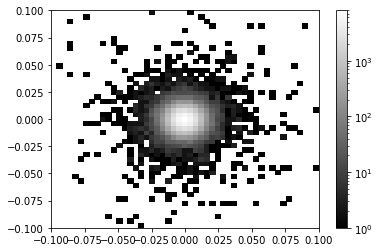

In [30]:
bins = (np.linspace(-0.1, 0.1, 50), np.linspace(-0.1, 0.1, 50))
n = plt.hist2d(tracks_109_x, tracks_109_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)
plt.colorbar()
np.max(n[0])

## save data

In [31]:
# '''
df = pd.DataFrame()
df['tracks_109_x'] = tracks_109_x
df['tracks_109_y'] = tracks_109_y
df['tracks_109_z'] = tracks_109_z
df['tracks_109_pos_x'] = tracks_109_pos_x
df['tracks_109_pos_y'] = tracks_109_pos_y
df['tracks_109_pos_z'] = tracks_109_pos_z
df['tracks_109_zenith'] = tracks_109_zenith
df['tracks_109_azimuth'] = tracks_109_azimuth
key = 'E{}_only_{}_v_cut{}'.format(int(E_i), scattering_method, v_cut)
df.to_hdf(data_dir + 'sim_data.hdf5', key=key)
print(key)
# '''

E199_only_moliere_v_cut1e-05


/home/pgutjahr/proposal_7_3_0/lib64/python3.6/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'E199_only_moliere_v_cut1e-05'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## read data

In [33]:
key_0 = 'E199_moliere_v_cut0.001'
df_0 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_0)
# df_0.to_hdf(data_dir + 'sim_data.hdf5', key=key_0)

key_1 = 'E168_moliere_v_cut0.001'
df_1 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_1)
# df_1.to_hdf(data_dir + 'sim_data.hdf5', key=key_1)

key_2 = 'E199_highland_v_cut0.001'
df_2 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_2)
# df_2.to_hdf(data_dir + 'sim_data.hdf5', key=key_2)

key_3 = 'E168_highland_v_cut0.001'
df_3 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_3)
# df_3.to_hdf(data_dir + 'sim_data.hdf5', key=key_3)

key_4 = 'E168_moliere_v_cut1e-05'
df_4 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_4)
# df_4.to_hdf(data_dir + 'sim_data.hdf5', key=key_4)

key_5 = 'E199_moliere_v_cut1e-05'
df_5 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_5)
# df_5.to_hdf(data_dir + 'sim_data.hdf5', key=key_5)

key_6 = 'E199_moliere_v_cut1e-05_G4defl'
df_6 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_6) # not relevant because there are only ionizations -> hence the
# deflection parametrization for brems and nuclint does not effect anything

key_7 = 'E199_only_moliere_v_cut1e-05'
df_7 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_7)

# Plot all 

In [15]:
binning = [Attwood.angle[i] - abs(Attwood.angle[i+1] - Attwood.angle[i])/2 for i in range(len(Attwood)-1)]
binning.append(Attwood.angle.values[-1] - abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)
binning.append(Attwood.angle.values[-1] + abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)
binning

[-0.11478016838166513,
 -0.09363891487371379,
 -0.07511693171188027,
 -0.059401309635173066,
 -0.04639850327408795,
 -0.034424695977549116,
 -0.02450888681010291,
 -0.016463985032740897,
 -0.008980355472404127,
 -0.0031805425631431378,
 0.0021515434985967946,
 0.008325537885874632,
 0.015247895229186181,
 0.024789522918615487,
 0.033489242282507006,
 0.045743685687558454,
 0.05846585594013095,
 0.07427502338634238,
 0.09429373246024321,
 0.11431244153414404]

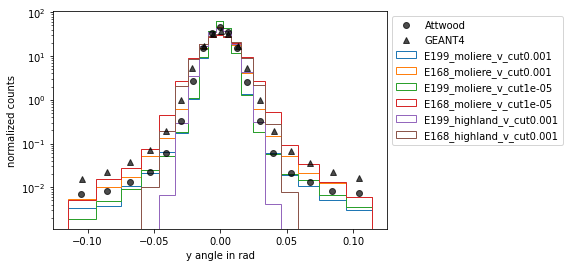

In [16]:
# plot y direction


plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning # np.linspace(-0.11, 0.11, 50)
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label=key_0)
plt.hist(df_1.tracks_109_y, bins=bins, histtype='step', density=True, label=key_1)
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label=key_5)
plt.hist(df_4.tracks_109_y, bins=bins, histtype='step', density=True, label=key_4)
plt.hist(df_2.tracks_109_y, bins=bins, histtype='step', density=True, label=key_2)
plt.hist(df_3.tracks_109_y, bins=bins, histtype='step', density=True, label=key_3)
# plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)



plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(plot_dir + 'attwood_comparison_all.pdf', bbox_inches='tight')

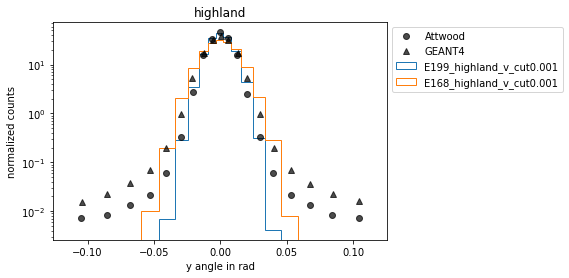

In [17]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

binning = [Attwood.angle[i] - abs(Attwood.angle[i+1] - Attwood.angle[i])/2 for i in range(len(Attwood)-1)]
binning.append(Attwood.angle.values[-1] - abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)
binning.append(Attwood.angle.values[-1] + abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)

bins = binning # np.linspace(-0.11, 0.11, 50)
plt.hist(df_2.tracks_109_y, bins=bins, histtype='step', density=True, label=key_2)
plt.hist(df_3.tracks_109_y, bins=bins, histtype='step', density=True, label=key_3)



plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.title('highland')
plt.savefig(plot_dir + 'attwood_comparison_highland.pdf', bbox_inches='tight')

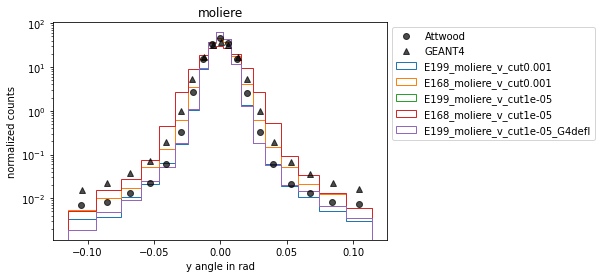

In [18]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning # np.linspace(-0.11, 0.11, 50)
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label=key_0)
plt.hist(df_1.tracks_109_y, bins=bins, histtype='step', density=True, label=key_1)
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label=key_5)
plt.hist(df_4.tracks_109_y, bins=bins, histtype='step', density=True, label=key_4)
plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)


plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.title('moliere')
plt.savefig(plot_dir + 'attwood_comparison_moliere.pdf', bbox_inches='tight')

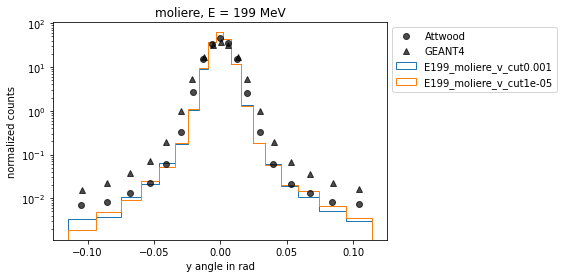

In [19]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label=key_0)
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label=key_5)
#plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)


plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.title('moliere, E = 199 MeV')
plt.savefig(plot_dir + 'attwood_comparison_moliere_E199.pdf', bbox_inches='tight')

moliere, E = 199 MeV


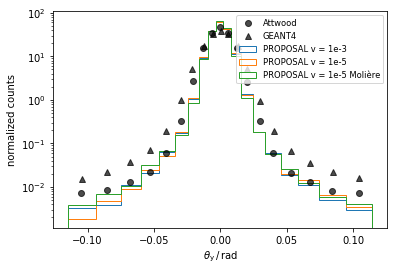

In [34]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label='PROPOSAL v = 1e-3')
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label='PROPOSAL v = 1e-5')
plt.hist(df_7.tracks_109_y, bins=bins, histtype='step', density=True, label='PROPOSAL v = 1e-5 Molière')
# plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)


plt.ylabel('normalized counts')
# plt.xlabel('y angle in rad')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$rad')
plt.yscale('log')
plt.legend(loc='upper right', fontsize='small')
print('moliere, E = 199 MeV')
plt.savefig(plot_dir + 'attwood_comparison_moliere_E199MeV_final.pdf', bbox_inches='tight')